In [115]:
#reqMktData does not seem to do anything, returns the same stuff as qualify
#reqTickers provides some relatvent information but seems it's off from market quotes
#Ticker(contract=Contract(secType='IND', conId=416904, symbol='SPX', exchange='CBOE', currency='USD', localSymbol='SPX'), time=datetime.datetime(2023, 5, 8, 2, 6, 47, 487024, tzinfo=datetime.timezone.utc), minTick=0.01, bid=-1.0, bidSize=0.0, ask=-1.0, askSize=0.0, close=4061.22)

In [1]:
from matplotlib import pyplot as plt
import math
import pandas as pd
import numpy as np

from ib_insync import *
util.startLoop()
#util.logToConsole('DEBUG')
ib = IB()
#make sure only one cliendID can run at a time, you can allow multiple cliendId to run at the same time
#when using 7497, only log into PAPER account, 7496 for REAL MONEY
ib.disconnect()
ib.connect('127.0.0.1', 7496, clientId=7) 

<IB connected to 127.0.0.1:7496 clientId=7>

In [2]:
'''quick check API is working '''

ticker = Stock('TSLA', 'SMART', 'USD')
ib.qualifyContracts(ticker) #Fully qualify the given contracts in-place. This will fill in the missing fields in the contract, especially the conId.

#ib.reqHeadTimeStamp(ticker, whatToShow='TRADES', useRTH=True) #reqHeadTimeStamp: returns the datetime of earliest available historical data for the contract. whatToShow: Specifies the source for constructing bars.  Can be 'TRADES', 'MIDPOINT', 'BID' or 'ASK'.

bars = ib.reqHistoricalData(
        ticker,
        endDateTime='',
        durationStr='1 Y',  #durationStr='2 D'
        barSizeSetting='1 hour',  #barSizeSetting='2 mins'
        whatToShow='TRADES',
        useRTH=True,
        formatDate=1)
df = util.df(bars)
df.head(1)
#util.barplot(bars[-100:], title=ticker.symbol); # need ;, otherwise will return 2 plots

,date,open,high,low,close,volume,average,barCount
0,2022-05-06 09:30:00,295.6667,295.8267,281.0333,284.52,81484.29,286.398333,14195


### SPX Option

#### helper functions

In [3]:
'''
helper function, used to obtain nearest whole number around spot to get ATM option
5.1 -> 5 or 6 depending on floor or ceiling
'''
def round_to_nearest(num, min_tick = 5, return_lower = True):
    num = int(num)
    if num % min_tick == 0:  # if already divisible by 5, should be atm for both call and put, return the number as is
        return num
    else:
        lower_num = (num // min_tick) * min_tick  # round down to nearest multiple of 5
        upper_num = (num // min_tick + 1) * min_tick  # round up to nearest multiple of 5
        return lower_num if return_lower else upper_num

In [4]:
'''
obtain customized option chain.
Ticker:
    ib.qualified ticker

b1,b2:
    When selection strikes, for both put and call select all that:

        lower_bound_put < put_strike < upper_bound_put

    b1: the percentage move reflecting lower bound
    b2: the percentage move reflecting upper bound

    ex: 
        b1 = 2, b2 = 5, spotVal = 200

    strikes to be considered:
    put strikes : (100-5)%*200 - (100-2)%*200 -> [190, ..., 196]
    call strikes: (100+2)%*200 - (100+5)%*200 -> [204, ..., 215]

atm_only
    return option chain with atm strikes only, one atm call option, one atm put option

'''
def get_option_chain(ticker,  bd1, bd2, atm_only = False):
    # bd1 = 2
    # bd2 = 5

    # '''get option chain'''
    # ticker = Contract(symbol='SPX',secType='IND')
    # ib.qualifyContracts(ticker) #Fully qualify the given contracts in-place. This will fill in the missing fields in the contract, especially the conId.
    # tickers=ib.reqTickers(ticker)
    # ticker = tickers[0]

    recent_bars=ib.reqHistoricalData(contract=ticker, endDateTime='', durationStr='30 s', barSizeSetting='30 secs', whatToShow='TRADES', useRTH=True, formatDate='1')
    recent_data = util.df(bars)
    spotVal = recent_data.close[0]

    #chains contains total 6, (3xcall, 3xput) SMART, IBUSPOT,CBOE three 'exchanges' 
    chains=ib.reqSecDefOptParams(ticker.symbol,'',ticker.secType, ticker.conId)
    if ticker.secType == 'STK':
        chain=[c for c in chains if c.exchange=='SMART'][0]

    else:
        chain=[c for c in chains if c.tradingClass=='SPXW' and c.exchange=='SMART'][0]
    
    idx = (np.abs(np.array(chain.strikes) - spotVal)).argmin()

    nearby_strikes = chain.strikes[idx:idx+2]
    min_tick = nearby_strikes[1] - nearby_strikes[0]

    strikes=[stk for stk in chain.strikes if ((spotVal*(1-bd2/100) <= stk <= spotVal*(1-bd1/100)) or (spotVal*(1+bd1/100) <= stk <= spotVal*(1+bd2/100)))][::-1]

    exp = sorted(exp for exp in chain.expirations)[:1][0] #[0] for the shortest maturity

    contracts = []
    
    if not atm_only:
        for stk in strikes:
            right = 'C' if stk > spotVal else 'P'
            contracts.append(Option(ticker.symbol, exp, stk, right, 'SMART'))

    atm_call_strike = round_to_nearest(spotVal, min_tick, True)
    atm_put_strike = round_to_nearest(spotVal, min_tick, False)

    contracts.extend([Option(ticker.symbol, exp, atm_call_strike, 'C','SMART'), Option(ticker.symbol, exp, atm_put_strike, 'P','SMART')])

    contracts=ib.qualifyContracts(*contracts)
    tickers=ib.reqTickers(*contracts) #reqTickers, take ~1 sec for each  strike


    '''to change to Tony's in house greek computation'''
    ls = []
    for ticker in tickers:
        right = ticker.contract.right
        strike = ticker.contract.strike
        strike_pct = (strike/spotVal - 1)*100

        try:
            delta = ticker.modelGreeks.delta
            iv = ticker.modelGreeks.impliedVol
        except:
            delta = 0
            iv = 0

        bid = ticker.bid
        ask = ticker.ask

        ls.append([right, strike, strike_pct, iv, bid, ask, delta])

    columns = ['Option', 'Strike', '%_VS_Spot','IV', 'Bid', 'Ask', 'Delta']
    option_chain = pd.DataFrame(ls, columns = columns).sort_values('Strike', ascending = False).reset_index(drop=True)
    option_chain[['%_VS_Spot', 'IV']] = option_chain[['%_VS_Spot', 'IV']].round(3)
    option_chain[['Delta']] = option_chain[['Delta']]*100

    symbol = ticker.contract.symbol #    print(ticker.contract.symbol + ' Spot: ',spotVal)
    spotVal = spotVal
    exp_date = ticker.contract.lastTradeDateOrContractMonth #    print('Expiration: ', ticker.contract.lastTradeDateOrContractMonth)
    atm_iv = option_chain[option_chain.Strike.isin([atm_call_strike,atm_put_strike])].IV.mean() #    print('ATM Option IV: ',option_chain[option_chain.Strike.isin([atm_call_strike,atm_put_strike])].IV.mean())#average of ATM call, put IV

    return spotVal, exp_date, atm_iv, option_chain


In [5]:
symbols = ['SPX']#, 'TSLA']#'AAPL','TSLA','KRE',]#, 'IWM', 'FEZ']

scanner = []
option_chain_dic = {}

for symbol in symbols:
    if symbol == 'SPX':
        ticker = Contract(symbol=symbol, secType = 'IND' )

    else:
        ticker = Contract(symbol=symbol, secType = 'STK', exchange = 'SMART', currency='USD' )

    ib.qualifyContracts(ticker) 
    #ib.reqHeadTimeStamp(ticker, whatToShow='TRADES', useRTH=True)

    #estimate hv
    bars=ib.reqHistoricalData(
        contract=ticker,
        endDateTime='',
        durationStr='10 D',
        barSizeSetting='30 mins',
        whatToShow='TRADES',
        useRTH=True,
        formatDate='1'
    )
    df=util.df(bars)
    df['returns'] = (df['open'] / df['close'])
    hv_10d = df['returns'].std()*np.sqrt(13)*np.sqrt(252)*100

    #yesterday return
    bars=ib.reqHistoricalData(
        contract=ticker,
        endDateTime='',
        durationStr='11 D',
        barSizeSetting='1 day',
        whatToShow='TRADES',
        useRTH=True,
        formatDate='1'
    )
    df=util.df(bars)
    ret_series = df.close.pct_change()
    ret_10_median =  ret_series.abs().median()*100
    ret_1d = ret_series[df.shape[0]-1]*100

    #option data
    spotVal, exp_date, atm_iv, option_chain = get_option_chain(ticker, atm_only = True, bd1 = 2*ret_10_median, bd2 = 6*ret_10_median)
    atm_iv = atm_iv*100
    option_chain_dic[symbol] = option_chain.copy()

    scanner.append([exp_date, symbol, spotVal, hv_10d, atm_iv,  ret_10_median, ret_1d])
columns = ['Expiration', 'Ticker', 'SpotVal','HV_10D', 'ATM_IV', 'Ret_10D Median %', 'RET_1D %']

scanner_df = pd.DataFrame(scanner, columns = columns)
scanner_df['IV-HV'] = scanner_df['ATM_IV'] - scanner_df['HV_10D']

scanner_df[['ATM_IV', 'HV_10D', 'IV-HV']] = scanner_df[['ATM_IV', 'HV_10D', 'IV-HV']].round(3)
scanner_df[['Ret_10D Median %', 'RET_1D %']] = scanner_df[['Ret_10D Median %', 'RET_1D %']].round(3)

scanner_df = scanner_df.sort_values('IV-HV', ascending = False).reset_index(drop=True)
scanner_df


,Expiration,Ticker,SpotVal,HV_10D,ATM_IV,Ret_10D Median %,RET_1D %,IV-HV
0,20230508,SPX,4133.52,11.461,15.35,0.774,1.847,3.889


SPX 4133.52 20230508
Return 10D Median:  0.774
Range:  0.9288   2.709


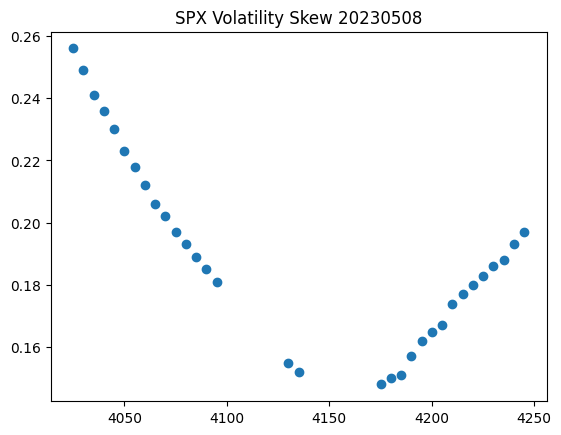

,Option,Strike,%_VS_Spot,IV,Bid,Ask,Delta
0,C,4245.0,2.697,0.197,-1.00,0.05,0.074676
1,C,4240.0,2.576,0.193,-1.00,0.05,0.096661
2,C,4235.0,2.455,0.188,-1.00,0.05,0.122959
3,C,4230.0,2.334,0.186,-1.00,0.10,0.175085
4,C,4225.0,2.213,0.183,-1.00,0.10,0.244210
5,C,4220.0,2.092,0.180,-1.00,0.10,0.336453
6,C,4215.0,1.971,0.177,-1.00,0.10,0.459579
7,C,4210.0,1.850,0.174,0.05,0.10,0.624519
8,C,4205.0,1.729,0.167,0.05,0.15,0.742894
9,C,4200.0,1.608,0.165,0.10,0.15,1.109582


In [8]:
rank = 0
refresh = True
bb1_multiply = 1.2
bb2_multiply = 3.5

symbol, spotVal, atm_iv, exp, ret_10_median = scanner_df.Ticker[rank], scanner_df.SpotVal[rank], scanner_df.ATM_IV[rank], scanner_df.Expiration[rank], scanner_df['Ret_10D Median %'][rank]
print(symbol, spotVal, exp)
print('Return 10D Median: ',ret_10_median)
print('Range: ', bb1_multiply*ret_10_median, ' ', bb2_multiply*ret_10_median)
option_chain = option_chain_dic[symbol]

if refresh:
    ticker = Contract(symbol=symbol, secType = 'IND')
    ib.qualifyContracts(ticker) 
    _, _, _, option_chain = get_option_chain(ticker, bd1 = bb1_multiply*ret_10_median, bd2 = bb2_multiply*ret_10_median)

plt.scatter(option_chain.Strike, option_chain.IV)
plt.title(symbol +' Volatility Skew '+exp)
plt.show()

option_chain

### SPREAD_UTIL

In [ ]:
import spread_util
short_leg=[ticker for ticker in tickers if (ticker.lastGreeks.delta != None)\
           and(0.04<=abs(ticker.lastGreeks.delta)<=0.06)][0]
long_leg=[ticker for ticker in tickers if ticker.contract.strike==(short_leg.contract.strike-20)][0]
spread_price, stop_price=spread_util.calc_spread_price(ib,spread_util.SpreadType.BULLPUT,long_leg.contract,short_leg.contract,0,1)
spread_contract=spread_util.create_vertical_spread(long_leg.contract,short_leg.contract)
spread_order=LimitOrder('BUY',5,spread_price)
trade=ib.placeOrder(spread_contract,spread_order)
trade.log

In [ ]:
ib.disconnect()

In [ ]:
# #official tws api
# from ibapi.client import *
# from ibapi.wrapper import *
# class TestApp(EClient, EWrapper):
#     def __init__(self):
#         EClient.__init__(self, self)
#     def nextValidId(self, orderId: int):
        
#         mycontract = Contract()
#         mycontract.symbol = "AAPL"
#         mycontract.secType = "STK"
#         mycontract.exchange = "SMART"
#         mycontract.currency = "USD"
#         print('here')
#         self.reqHistoricalData(orderId, mycontract, "20230502 15:59:00 US/Eastern", "1 D", "1 hour", "TRADES", 0, 1, 0, [])
#     def historicalData(self, reqId, bar):
#         print(f"Historical Data: {bar}")
#     def historicalDataEnd(self, reqId, start, end):
#         print(f"End of HistoricalData")
#         print(f"Start: {start}, End: {end}")
# app = TestApp()
# app.connect("127.0.0.1", 7496, 1000)
# app.run()

# #app.disconnect()